In [3]:
import os
import numpy as np

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import load_img, ImageDataGenerator
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten


In [6]:
count = 0
dirs = os.listdir('flowers/')
for dir in dirs:
    files = list(os.listdir('flowers/'+dir))
    print( dir +' Folder has '+ str(len(files)) + ' flowers')
    count = count + len(files)
print( 'Flowers Folder has '+ str(count) + ' flowers')

rose Folder has 784 flowers
dandelion Folder has 1052 flowers
sunflower Folder has 733 flowers
daisy Folder has 764 flowers
tulip Folder has 984 flowers
flowers Folder has 4317 flowers


In [7]:
#Loading Images into Arrays as Dataset

In [8]:
base_dir = 'flowers/'
img_size = 180
batch = 32

In [9]:
train_ds = tf.keras.utils.image_dataset_from_directory( base_dir,
                                                       seed = 123,
                                                       validation_split=0.2,
                                                       subset = 'training',
                                                       batch_size=batch,
                                                       image_size=(img_size,img_size))

val_ds = tf.keras.utils.image_dataset_from_directory( base_dir,
                                                       seed = 123,
                                                       validation_split=0.2,
                                                       subset = 'validation',
                                                       batch_size=batch,
                                                       image_size=(img_size,img_size))

Found 4317 files belonging to 5 classes.
Using 3454 files for training.
Found 4317 files belonging to 5 classes.
Using 863 files for validation.


In [10]:
flower_names = train_ds.class_names
flower_names

['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']

In [11]:
import matplotlib.pyplot as plt

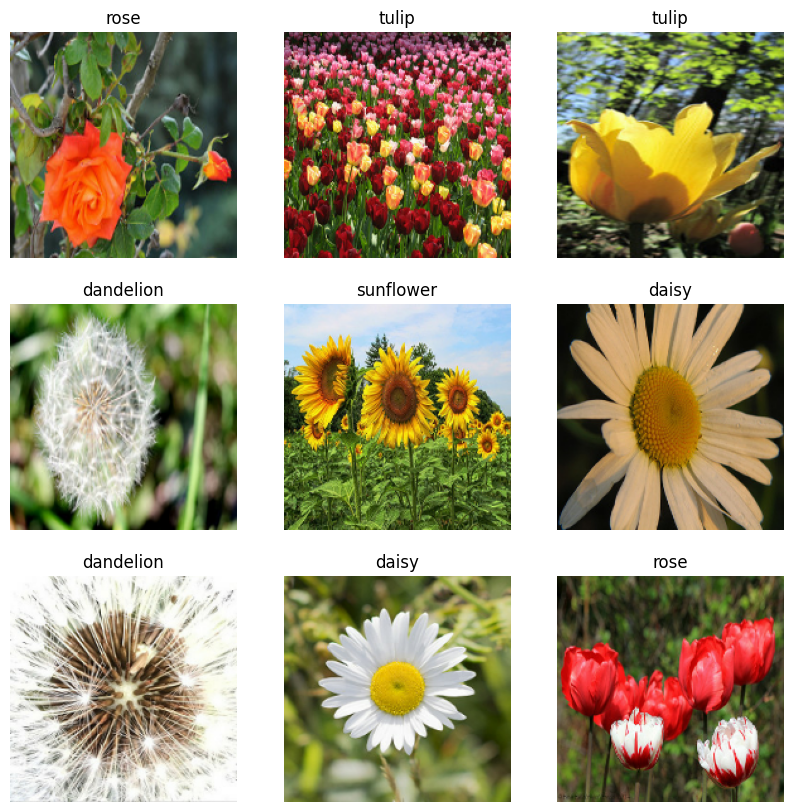

In [12]:
i = 0
plt.figure(figsize=(10,10))

for flowers, labels in train_ds.take(1):
    for i in range(9):
        plt.subplot(3,3, i+1)
        plt.imshow(flowers[i].numpy().astype('uint8'))
        plt.title(flower_names[labels[i]])
        plt.axis('off')

In [13]:
AUTOTUNE = tf.data.AUTOTUNE

In [14]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = AUTOTUNE)

In [15]:
val_ds = val_ds.cache().prefetch(buffer_size = AUTOTUNE)

In [17]:
#Now, we are gonna do data augmentation because total mein we have 4000 images in it, and kunki real world data set almost TB wali size
#jitne hote hain to data augmentation ek image ko pakadta hai, use random flip/room/rotate karta hai taaki humara data set thoda sa badha ho sake

In [18]:
data_augmentation = Sequential([
    layers.RandomFlip("horizontal", input_shape = (img_size,img_size,3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1)
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


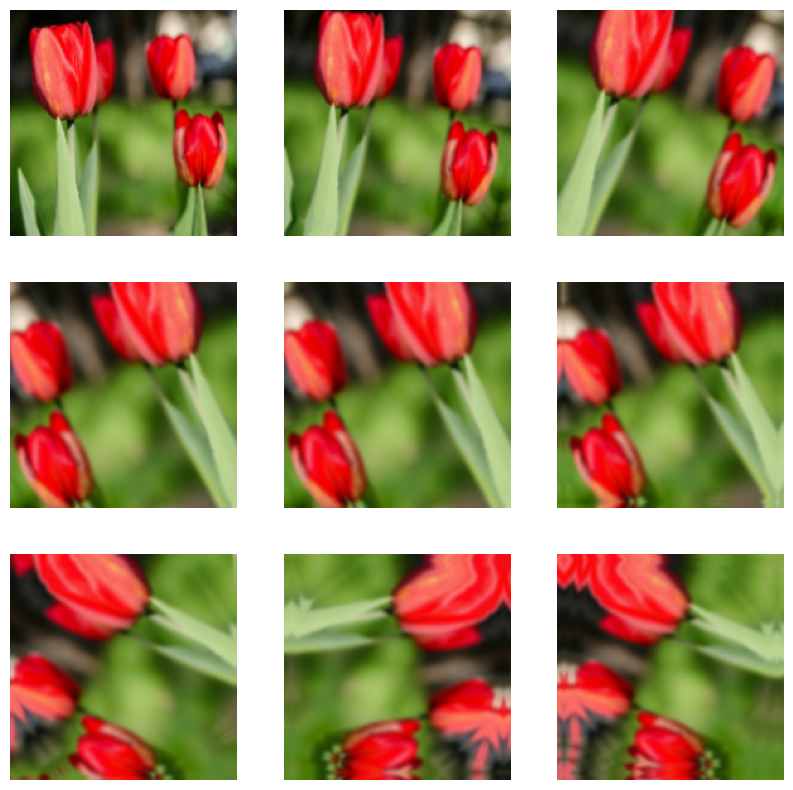

In [21]:
i = 0
plt.figure(figsize=(10,10))

for flowers, labels in train_ds.take(1):
    for i in range(9):
        flowers = data_augmentation(flowers)
        plt.subplot(3,3, i+1)
        plt.imshow(flowers[0].numpy().astype('uint8'))
        plt.axis('off')

In [22]:
#Creating a model

In [23]:
model = Sequential([
    data_augmentation,
    layers.Rescaling(1./255), # This layer rescales the pixel values of the input images from the range [0, 255] to [0, 1].
                              #This normalization helps the model learn more effectively.
    Conv2D(16, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Dropout(0.2),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(5)
])

In [24]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [25]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 180, 180, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 90, 90, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 90, 90, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 45, 45, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 30976)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,965,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,989,285 (15.22 MB)

 Trainable params: 3,989,285 (15.22 MB)

 Non-trainable params: 0 (0.00 B)

In [26]:
history = model.fit(train_ds, epochs=15, validation_data=val_ds)

Epoch 1/15
108/108 ━━━━━━━━━━━━━━━━━━━━ 138s 1s/step - accuracy: 0.3081 - loss: 1.7259 - val_accuracy: 0.5388 - val_loss: 1.1558
Epoch 2/15
108/108 ━━━━━━━━━━━━━━━━━━━━ 131s 1s/step - accuracy: 0.5190 - loss: 1.1631 - val_accuracy: 0.5214 - val_loss: 1.1618
Epoch 3/15
108/108 ━━━━━━━━━━━━━━━━━━━━ 128s 1s/step - accuracy: 0.5973 - loss: 1.0497 - val_accuracy: 0.6269 - val_loss: 0.9570
Epoch 4/15
108/108 ━━━━━━━━━━━━━━━━━━━━ 130s 1s/step - accuracy: 0.6195 - loss: 0.9751 - val_accuracy: 0.6466 - val_loss: 0.9260
Epoch 5/15
108/108 ━━━━━━━━━━━━━━━━━━━━ 130s 1s/step - accuracy: 0.6554 - loss: 0.8922 - val_accuracy: 0.6559 - val_loss: 0.8963
Epoch 6/15
108/108 ━━━━━━━━━━━━━━━━━━━━ 144s 1s/step - accuracy: 0.6774 - loss: 0.8163 - val_accuracy: 0.6929 - val_loss: 0.8014
Epoch 7/15
108/108 ━━━━━━━━━━━━━━━━━━━━ 125s 1s/step - accuracy: 0.7124 - loss: 0.7578 - val_accuracy: 0.6929 - val_loss: 0.8020
Epoch 8/15
108/108 ━━━━━━━━━━━━━━━━━━━━ 130s 1s/step - accuracy: 0.7179 - loss: 0.7361 - val_accu

In [27]:
def classify_images(image_path):
    input_image = tf.keras.utils.load_img(image_path, target_size=(180,180))
    input_image_array = tf.keras.utils.img_to_array(input_image)
    input_image_exp_dim = tf.expand_dims(input_image_array,0)

    predictions = model.predict(input_image_exp_dim)
    result = tf.nn.softmax(predictions[0])
    outcome = 'The Image belongs to ' + flower_names[np.argmax(result)] + ' with a score of '+ str(np.max(result)*100)
    return outcome

In [29]:
model.save('Flower_Recog_Model.h5')